<a href="https://colab.research.google.com/github/TottiPuc/MIDDLE-Net_superResolution/blob/main/Sandwich_deep_prior_pavia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libs

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/') 
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/
Mounted at /content/gdrive/


In [ ]:
%cd "/content/gdrive/MyDrive/Colab Notebooks/sandwich"
%ls

/content/gdrive/MyDrive/Colab Notebooks/sandwich
 bands.csv                        Firmas_espectrales.ipynb
 clasificador_de_frutoas.ipynb    models/
 CompositeRGBFusion.m             models1/
 CubeNet_rgb2hyper.ipynb          output/
 data/                            results/
'data (1)'/                       results1/
 deblurring_dip.ipynb             results2/
 deblurring_sandwich.ipynb        rgbTOhyper_GAN.ipynb
 deep_denoising_barbara.ipynb     RGBtoHYPER_GANs.ipynb
 degradation.mat                  sandwich1/
 degradationModelH1H2             Sandwich_deep_prior_Compresive_pavia.ipynb
 E2E_sandwich_pavia.ipynb         Sandwich_deep_prior.ipynb
 e2e_sandwich.py                  Sandwich_deep_prior_pavia.ipynb
 E2E_sandwich_salinas_0.ipynb     Sandwich_deep_prior_salinas.ipynb
 E2E_sandwich_salinas.ipynb       utils/
 firmas_espectrales_final.ipynb


In [ ]:
from __future__ import print_function
import matplotlib.pyplot as pl
from skimage.metrics import peak_signal_noise_ratio
 #os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np

import torch
import torch.optim

import scipy.io
from skimage.measure import compare_psnr
from models.downsampler import *
#from models.degradation import Spatial_blurring, spectral_blurri,gaussian
from models.resnet import ResNet
from models.unet import UNet
from models.unet_up import UNet_up
from models.skip import skip
from torch.nn import functional as F
from models.MAIN import *


from utils.sr_utils import *

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

## Parameters to consider

In [ ]:
p_factor = 4 #2  # spatial factor  # to evaluate []
q_factor = 8 #16  # Number of spectral bands

data_set = 'pavia'
LR = 0.001   # learning rate parameter to evaluate #[0.005, 0.001, 0.0005]
reg_noise_std = 0  # try 0 0.03 0.05 0.08

#reg_loss=[0.5,0.5,0.5]
reg_loss=[1.0,1.0,1.0]
name_save = 'Dataset_'+data_set+'_p_factor_'+str(p_factor)+'_q_bands_'+str(q_factor)+'_LR_'+str(LR)+'_perturbed_'+str(reg_noise_std)+'_loss_'+str(reg_loss)+'draw'
print(name_save)

Path = 'results/'+name_save
try:
  os.stat(Path)
except:
  os.mkdir(Path)

Dataset_pavia_p_factor_4_q_bands_8_LR_0.001_perturbed_0_loss_[1.0, 1.0, 1.0]draw


# Load image and baselines

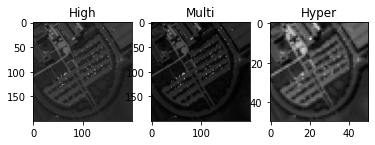

In [ ]:
file_name  = 'data/'+data_set+'.mat'
imgs = scipy.io.loadmat(file_name)
#plot band
band = 16

HR = imgs['HR2'].transpose(2,0,1)
HR = torch.from_numpy(HR).type(dtype)
HR = HR[None, :].cuda()

# Low resolution Image

KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=imgs['HR2'].shape[2], factor=p_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
img_hyper = torch.from_numpy(downsampler(HR).detach().cpu().numpy()).type(dtype)
mostr = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,1),plt.imshow(imgs['HR2'][:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,3),plt.imshow(mostr[:, :, band],cmap='gray'),plt.title('Hyper')

dw_spectral = spectral_blurring(Input_band=96,factor=q_factor,type='decimation')
img_LR_var = torch.from_numpy(dw_spectral(HR).detach().cpu().numpy()).type(dtype)
#mostr = img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
mostr = img_LR_var[0].detach().cpu().numpy().transpose(1, 2, 0)
plt.subplot(1,3,2),plt.imshow(mostr[:, :, 0],cmap='gray'),plt.title('Multi')
plt.show()


img_Multi = img_LR_var

In [ ]:
imgs['HR2'].shape

(200, 200, 96)

In [ ]:
hyper = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
scipy.io.savemat("/content/sample_data/degradation.mat", {'pred': np.clip(hyper, 0, 1)})

In [ ]:
out = img_LR_var[0].detach().cpu().numpy().transpose(1, 2, 0)
scipy.io.savemat("/content/sample_data/degradation1.mat", {'pred': np.clip(out, 0, 1)})

# Set up parameters and net

In [ ]:
input_depth = img_Multi.shape[1]
method =    '2D'
pad   =     'reflection'
pad2 = 'same'
OPT_OVER =  'net'

show_every = 100


tv_weight = 0.0
OPTIMIZER = 'adam'
num_iter = 10002
save_every = int(num_iter/5)

In [ ]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from models.common import * 

class UNet_up1(nn.Module):
    '''
        upsample_mode in ['deconv', 'nearest', 'bilinear']
        pad in ['zero', 'replication', 'none']
    '''
    def __init__(self, num_input_channels=3, num_output_channels=3, 
                       feature_scale=4, more_layers=0, concat_x=False,
                       upsample_mode='deconv', pad='zero', norm_layer=nn.InstanceNorm2d, need_sigmoid=True, need_bias=True):
        super(UNet_up1, self).__init__()

        self.feature_scale = feature_scale
        self.more_layers = more_layers
        self.concat_x = concat_x


        #filters = [64, 128, 256, 512, 1024]
        #filters = [86, 86, 86, 86, 86] #para pavia
        filters = [192, 192, 192, 192, 192]# para salinas
        #filters = [x // self.feature_scale for x in filters]

        self.start = unetConv2(num_input_channels, filters[3] , norm_layer, need_bias, pad)

        self.up4 = unetUp(filters[3], upsample_mode, need_bias, pad)
        self.up3 = unetUp(filters[2], upsample_mode, need_bias, pad)
        self.up2 = unetUp(filters[1], upsample_mode, need_bias, pad)
        #self.up1 = unetUp(filters[0], upsample_mode, need_bias, pad)


        self.final = conv(filters[0], num_output_channels, 1, bias=need_bias, pad=pad)

        if need_sigmoid: 
            self.final = nn.Sequential(self.final, nn.Sigmoid())


    def forward(self, inputs):
        #print(inputs.shape)
        in64 = self.start(inputs)
        up4= self.up4(in64)
        #print(up4.shape)
        up3= self.up3(up4)
        #print('esta ',up3.shape)
        up2= self.up2(up3)
        #print(up2.shape)
        #up1= self.up1(up2)
        #print(up1.shape)

        return self.final(up2)



class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetConv2, self).__init__()

        
        if norm_layer is not None:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv3= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),) 
            #self.conv4= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
             #                          nn.ReLU(),)        
        else:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv3= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
          #  self.conv4= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
           #                            nn.ReLU(),) 
            #self.conv5= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                #                       nn.ReLU(),)
            #self.conv6= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
               #                        nn.ReLU(),)    
            #self.conv7= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
              #                         nn.ReLU(),) 
            #self.conv8= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
             #                          nn.ReLU(),)                          
    def forward(self, inputs):
        outputs1= self.conv1(inputs)
        outputs2= self.conv2(outputs1) # hasta aqui
        outputs3= self.conv3(outputs2) # esta es demas
        #outputs4= self.conv4(outputs3) # esta de mas
        #outputs5= self.conv5(outputs4)
        #outputs6= self.conv5(outputs5)
        #outputs7= self.conv5(outputs6)
        #outputs= self.conv6(outputs7)
        return outputs3


class unetUp(nn.Module):
    def __init__(self, out_size, upsample_mode, need_bias, pad, same_num_filt=False):
        super(unetUp, self).__init__()

        num_filt = out_size if same_num_filt else out_size 
        if upsample_mode == 'deconv':
            self.up= nn.ConvTranspose2d(num_filt, out_size, 4, stride=2, padding=1)
            self.conv= unetConv2(out_size , out_size, None, need_bias, pad)
        elif upsample_mode=='bilinear' or upsample_mode=='nearest':
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode=upsample_mode),
                                   conv(num_filt, out_size, 3, bias=need_bias, pad=pad))
            self.conv= unetConv2(out_size , out_size, None, need_bias, pad)
        else:
            assert False

    def forward(self, inputs1):
        in1_up= self.up(inputs1)
        output= self.conv(in1_up)

        return output

In [ ]:
class UNet_pol(nn.Module):
    '''
        upsample_mode in ['deconv', 'nearest', 'bilinear']
        pad in ['zero', 'replication', 'none']
    '''
    def __init__(self, num_input_channels=3, num_output_channels=3, 
                       feature_scale=4, more_layers=0, concat_x=False,
                       upsample_mode='deconv', pad='zero', norm_layer=nn.InstanceNorm2d, need_sigmoid=True, need_bias=True):
        super(UNet_pol, self).__init__()

        self.feature_scale = feature_scale
        self.more_layers = more_layers
        self.concat_x = concat_x


        filters = [64, 128, 256, 512, 1024]
        filters = [x // self.feature_scale for x in filters]

        self.start = unetConv2(num_input_channels, filters[0] if not concat_x else filters[0] - num_input_channels, norm_layer, need_bias, pad)

        self.down1 = unetDown(filters[0], filters[1] if not concat_x else filters[1] - num_input_channels, norm_layer, need_bias, pad)
        self.down2 = unetDown(filters[1], filters[2] if not concat_x else filters[2] - num_input_channels, norm_layer, need_bias, pad)
        self.down3 = unetDown(filters[2], filters[3] if not concat_x else filters[3] - num_input_channels, norm_layer, need_bias, pad)
        self.down4 = unetDown(filters[3], filters[4] if not concat_x else filters[4] - num_input_channels, norm_layer, need_bias, pad)

        # more downsampling layers
        if self.more_layers > 0:
            self.more_downs = [
                unetDown(filters[4], filters[4] if not concat_x else filters[4] - num_input_channels , norm_layer, need_bias, pad) for i in range(self.more_layers)]
            self.more_ups = [unetUp(filters[4], upsample_mode, need_bias, pad, same_num_filt =True) for i in range(self.more_layers)]

            self.more_downs = ListModule(*self.more_downs)
            self.more_ups   = ListModule(*self.more_ups)

        self.up4 = unetUp(filters[3], upsample_mode, need_bias, pad)
        self.up3 = unetUp(filters[2], upsample_mode, need_bias, pad)
        #self.up2 = unetUp(filters[1], upsample_mode, need_bias, pad)
        #self.up1 = unetUp(filters[0], upsample_mode, need_bias, pad)

        self.final = conv(filters[2], num_output_channels, 1, bias=need_bias, pad=pad)

        if need_sigmoid: 
            self.final = nn.Sequential(self.final, nn.Sigmoid())

    def forward(self, inputs):

        # Downsample 
        downs = [inputs]
        down = nn.AvgPool2d(2, 2)
        for i in range(4 + self.more_layers):
            downs.append(down(downs[-1]))

        in64 = self.start(inputs)
        if self.concat_x:
            in64 = torch.cat([in64, downs[0]], 1)

        down1 = self.down1(in64)
        if self.concat_x:
            down1 = torch.cat([down1, downs[1]], 1)

        down2 = self.down2(down1)
        if self.concat_x:
            down2 = torch.cat([down2, downs[2]], 1)

        down3 = self.down3(down2)
        if self.concat_x:
            down3 = torch.cat([down3, downs[3]], 1)

        down4 = self.down4(down3)
        if self.concat_x:
            down4 = torch.cat([down4, downs[4]], 1)

        up_= down3

        #up4= self.up4(up_, down3)
        up3= self.up3(up_, down2)
        #up2= self.up2(up3, down1)
        #up1= self.up1(up2, in64)

        return self.final(up3)



class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetConv2, self).__init__()

        #print(pad)
        if norm_layer is not None:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
        else:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
    def forward(self, inputs):
        outputs= self.conv1(inputs)
        outputs= self.conv2(outputs)
        return outputs


class unetDown(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetDown, self).__init__()
        self.conv= unetConv2(in_size, out_size, norm_layer, need_bias, pad)
        self.down= nn.MaxPool2d(2, 2)

    def forward(self, inputs):
        outputs= self.down(inputs)
        outputs= self.conv(outputs)
        #print(outputs.shape)
        return outputs


class unetUp(nn.Module):
    def __init__(self, out_size, upsample_mode, need_bias, pad, same_num_filt=False):
        super(unetUp, self).__init__()

        num_filt = out_size if same_num_filt else out_size * 2
        if upsample_mode == 'deconv':
            self.up= nn.ConvTranspose2d(num_filt, out_size, 4, stride=2, padding=1)
            self.conv= unetConv2(out_size * 2, out_size, None, need_bias, pad)
        elif upsample_mode=='bilinear' or upsample_mode=='nearest':
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode=upsample_mode),
                                   conv(num_filt, out_size, 3, bias=need_bias, pad=pad))
            self.conv= unetConv2(out_size * 2, out_size, None, need_bias, pad)
        else:
            assert False

    def forward(self, inputs1, inputs2):
        in1_up= self.up(inputs1)
        
        if (inputs2.size(2) != in1_up.size(2)) or (inputs2.size(3) != in1_up.size(3)):
            diff2 = (inputs2.size(2) - in1_up.size(2)) // 2 
            diff3 = (inputs2.size(3) - in1_up.size(3)) // 2 
            inputs2_ = inputs2[:, :, diff2 : diff2 + in1_up.size(2), diff3 : diff3 + in1_up.size(3)]
        else:
            inputs2_ = inputs2

        output= self.conv(torch.cat([in1_up, inputs2_], 1))
        #print('up ', output.shape)
        return output

#H1-H2

In [ ]:
#HI-H2
net_input = img_Multi.type(dtype).detach()
net = skip(img_Multi.shape[1], imgs['HR2'].shape[2],
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

net2 = UNet_pol( imgs['HR2'].shape[2], img_hyper.shape[1],feature_scale=2).cuda()
# Losses
mse = torch.nn.MSELoss().type(dtype)

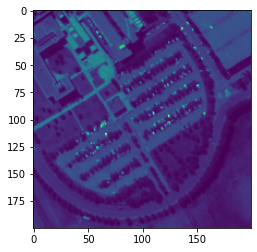

In [ ]:
net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()
net_input = net_input_saved + (noise.normal_() * reg_noise_std)
plt.imshow(net_input.cpu().detach().numpy()[0].transpose(1,2,0)[:,:,5])

# Define closure and optimize

In [ ]:
net_input.shape

torch.Size([1, 12, 200, 200])

In [ ]:
  out_HR = net(net_input) # entre Multi sale  high resultion

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


In [ ]:
out_HR.shape

torch.Size([1, 96, 200, 200])

In [ ]:
out_LR = downsampler(out_HR) # entra high sale hyper
out_LR.shape

torch.Size([1, 96, 50, 50])

In [ ]:
out_spectral =  dw_spectral(out_HR) # entra high sale multi
out_spectral.shape

torch.Size([1, 12, 200, 200])

In [ ]:
out_BR = net2(out_HR) # sale hyper
out_BR.shape

torch.Size([1, 96, 50, 50])

In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
      
      net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    #H1
    out_HR = net(net_input) # entre Multi sale  high resultion

    # decimation
    out_LR = downsampler(out_HR) # entra high sale hyper
    out_spectral =  dw_spectral(out_HR) # entra high sale multi

    #H2
    out_BR = net2(out_HR) # sale hyper

    #loss functions
    
    #total_loss  = reg_loss[0] * mse(img_hyper, out_LR)
    total_loss  = reg_loss[0] * mse(img_hyper, out_BR)
    total_loss += reg_loss[1] * mse(img_Multi, out_spectral)
    total_loss += reg_loss[2] * mse(out_LR ,out_BR )#peurba
    #total_loss += reg_loss[2] * mse(img_hyper ,out_BR)#original

    #*original **segunda
    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    psnr_LR = peak_signal_noise_ratio(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))

    # History
    psnr_history.append([psnr_LR, psnr_HR])

    if i % show_every == 0:
        clear_output(wait=True)
        save_result(performance(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)),name_save+'/results_HR')
        save_result(performance(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        out_Y_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        plt.imshow(out_Y_np[:, :, 5], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat(Path+"/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1


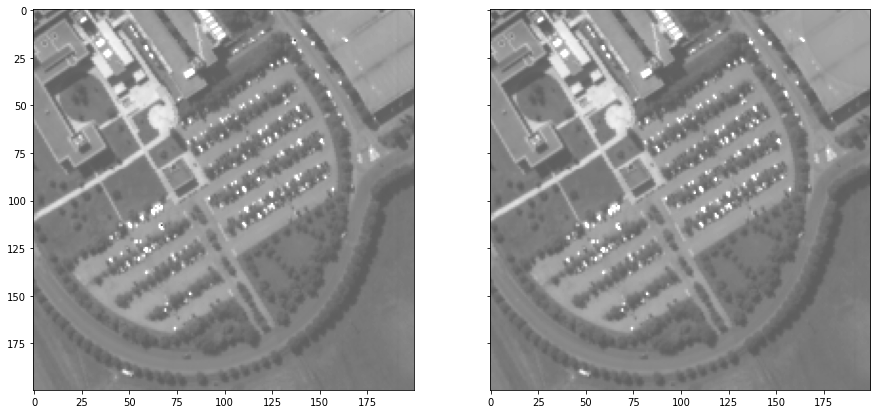

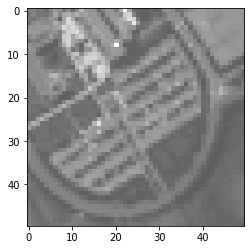

Iteration 10001, PSNR_HR 38.80,  PSNR_LR 49.49, total_loss 0.00003 


In [ ]:
psnr_history = []
if os.path.isfile(Path+'/results_HR.txt'):
  remove(Path+'/results_HR.txt')
if os.path.isfile(Path+'/results_LR.txt'):
  remove(Path+'/results_LR.txt')

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net2, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
  temp = np.zeros((imgs['HR2'].shape[0], imgs['HR2'].shape[1], imgs['HR2'].shape[2]))
  temp[100,100,:]=1.0
  #temp[101,101,:]=0.5
  

In [ ]:
hyper = temp
scipy.io.savemat("/content/sample_data/point.mat", {'pred': np.clip(hyper, 0, 1)})
OUT = temp.transpose(2,0,1)
OUT = torch.from_numpy(OUT).type(dtype)
OUT = OUT[None, :].cuda()
OUT.shape

torch.Size([1, 96, 200, 200])

In [ ]:
out_BR = net2(OUT) # sale hyper
out_BR.shape

torch.Size([1, 96, 50, 50])

In [ ]:
OUT_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)

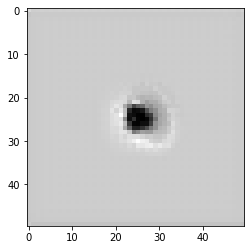

In [ ]:
plt.imshow(OUT_np[:, :, band],cmap='gray')

In [ ]:
torch.save(net2.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH1H2')

In [ ]:
new_model= torch.load('/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH1H2')

In [ ]:
modelo=UNet_pol( imgs['HR2'].shape[2], img_hyper.shape[1],feature_scale=2).cuda()

In [ ]:
modelo.load_state_dict(torch.load('/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH1H2'))

<All keys matched successfully>

In [ ]:


import pandas as pd
df_HR = pd.read_csv(Path+'/results_HR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_LR = pd.read_csv(Path+'/results_LR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_HR.head()

,PSNR_Spatial,PSNR_Spetral,PSNR_gen,RMSE,SNR,SAM,SSIM
0,41.266,37.552,40.370,0.0095,30.234,1.1360,0.9919
1,41.323,38.131,40.614,0.0093,30.478,1.0670,0.9926
2,41.328,37.739,40.415,0.0095,30.279,1.1165,0.9921
3,41.334,37.657,40.380,0.0095,30.243,1.1272,0.9920
4,41.340,37.631,40.371,0.0095,30.235,1.1301,0.9919


In [ ]:
np.max(df_HR["PSNR_Spatial"])

42.498000000000005

In [ ]:
np.max(df_HR["PSNR_Spetral"])

39.762

In [ ]:
np.max(df_HR["PSNR_gen"])

41.537

In [ ]:
np.max(df_HR["SNR"])

31.401

In [ ]:
np.max(df_HR["SAM"])

1.136

In [ ]:
np.max(df_HR["SSIM"])

0.9935

In [ ]:
imgs['HR2'].shape[2]

96

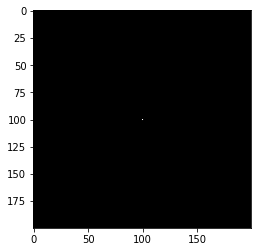

In [ ]:
plt.imshow(temp[:,:,95],cmap='gray')

In [ ]:
out_BR_N = modelo(OUT) # sale hyper
out_BR_N.shape

torch.Size([1, 96, 50, 50])

In [ ]:
OUT_np_N = out_BR_N.cpu().detach().numpy()[0].transpose(1, 2, 0)

In [ ]:
OUT_np.shape

(50, 50, 96)

In [ ]:
hyper = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)
scipy.io.savemat("/content/sample_data/degradationLearnedH1H2.mat", {'pred': np.clip(hyper, 0, 1)})

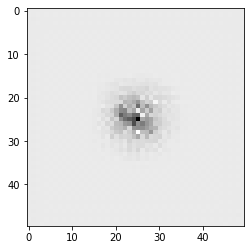

In [ ]:
plt.imshow(OUT_np[:, :, band],cmap='gray')

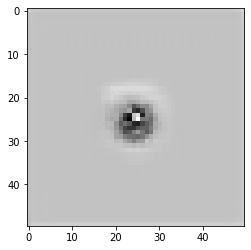

In [ ]:
plt.imshow(OUT_np_N[:, :, band],cmap='gray')

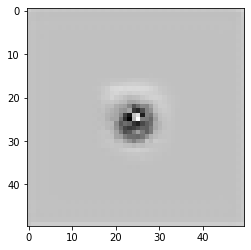

In [ ]:
plt.imshow(OUT_np[:, :, 19],cmap='gray')

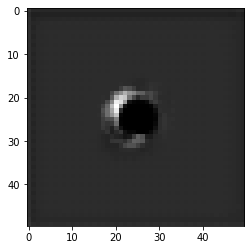

In [ ]:
plt.imshow(OUT_np[:, :, 49],cmap='gray')

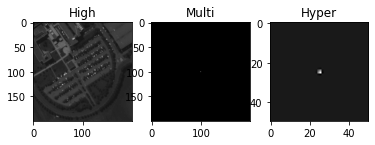

In [ ]:
KERNEL_TYPE='lanczos2'
downsampler = Downsampler(n_planes=imgs['HR2'].shape[2], factor=p_factor, kernel_type=KERNEL_TYPE, phase=0.5, preserve_size=True).type(dtype)
img_hyper = torch.from_numpy(downsampler(OUT).detach().cpu().numpy()).type(dtype)
mostr1 = img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
plt.subplot(1,3,1),plt.imshow(imgs['HR2'][:,:,band],cmap='gray'),plt.title('High')
plt.subplot(1,3,3),plt.imshow(mostr1[:, :, band],cmap='gray'),plt.title('Hyper')

dw_spectral = spectral_blurring(Input_band=96,factor=q_factor,type='decimation')
img_LR_var = torch.from_numpy(dw_spectral(OUT).detach().cpu().numpy()).type(dtype)
#mostr = img_LR_var.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
mostr = img_LR_var[0].detach().cpu().numpy().transpose(1, 2, 0)
plt.subplot(1,3,2),plt.imshow(mostr[:, :, 0],cmap='gray'),plt.title('Multi')
plt.show()

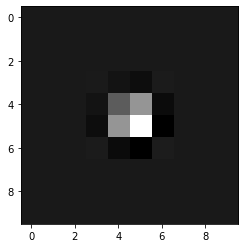

In [ ]:
plt.imshow(mostr1[20:30, 20:30, band],cmap='gray')

(<matplotlib.image.AxesImage at 0x7f4c60228e50>, Text(0.5, 1.0, 'Multi'))

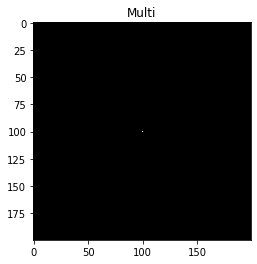

In [ ]:
plt.imshow(mostr[:, :, 0],cmap='gray'),plt.title('Multi')

In [ ]:
out_BR = net2(HR) # sale hyper
OUT_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)


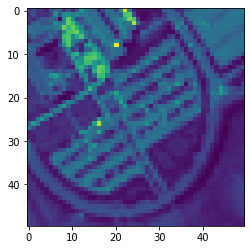

In [ ]:
plt.imshow(OUT_np[:, :, 9])

#H3-H4

In [ ]:
class UNet_up2(nn.Module):
    '''
        upsample_mode in ['deconv', 'nearest', 'bilinear']
        pad in ['zero', 'replication', 'none']
    '''
    def __init__(self, num_input_channels=3, num_output_channels=3, 
                       feature_scale=4, more_layers=0, concat_x=False,
                       upsample_mode='deconv', pad='zero', norm_layer=nn.InstanceNorm2d, need_sigmoid=True, need_bias=True):
        super(UNet_up2, self).__init__()

        self.feature_scale = feature_scale
        self.more_layers = more_layers
        self.concat_x = concat_x


        #filters = [64, 128, 256, 512, 1024]
        #filters = [96, 96, 96, 96, 96] para pavia
        filters = [92, 92, 92, 92, 92]# para salinas
        #filters = [x // self.feature_scale for x in filters]

        self.start = unetConv2(num_input_channels, filters[3] , norm_layer, need_bias, pad)

        self.up4 = unetUp(filters[3], upsample_mode, need_bias, pad)
        self.up3 = unetUp(filters[2], upsample_mode, need_bias, pad)
        #self.up2 = unetUp(filters[1], upsample_mode, need_bias, pad)
        #self.up1 = unetUp(filters[0], upsample_mode, need_bias, pad)


        self.final = conv(filters[0], num_output_channels, 1, bias=need_bias, pad=pad)

        if need_sigmoid: 
            self.final = nn.Sequential(self.final, nn.Sigmoid())


    def forward(self, inputs):
        in64 = self.start(inputs)
        #print(inputs.shape)
        up4= self.up4(in64)
        #print(up4.shape)
        up3= self.up3(up4)
        #print('esta ',up3.shape)
        #up2= self.up2(up3)
        #print(up2.shape)
        #up1= self.up1(up2)
        #print(up1.shape)

        return self.final(up3)



class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, norm_layer, need_bias, pad):
        super(unetConv2, self).__init__()

        
        if norm_layer is not None:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.ReLU(),)
            self.conv3= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv4= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),) 
        else:
            self.conv1= nn.Sequential(conv(in_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv2= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv3= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),)
            self.conv4= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                                       nn.ReLU(),) 
            #self.conv5= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
                #                       nn.ReLU(),)
            #self.conv6= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
               #                        nn.ReLU(),)    
            #self.conv7= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
              #                         nn.ReLU(),) 
            #self.conv8= nn.Sequential(conv(out_size, out_size, 3, bias=need_bias, pad=pad),
             #                          nn.ReLU(),)                          
    def forward(self, inputs):
        outputs1= self.conv1(inputs)
        outputs2= self.conv2(outputs1) # hasta aqui
        outputs3= self.conv3(outputs2) # esta es demas
        outputs4= self.conv4(outputs3) # esta de mas
        #outputs5= self.conv5(outputs4)
        #outputs6= self.conv5(outputs5)
        #outputs7= self.conv5(outputs6)
        #outputs= self.conv6(outputs7)
        return outputs4


class unetUp(nn.Module):
    def __init__(self, out_size, upsample_mode, need_bias, pad, same_num_filt=False):
        super(unetUp, self).__init__()

        num_filt = out_size if same_num_filt else out_size 
        if upsample_mode == 'deconv':
            self.up= nn.ConvTranspose2d(num_filt, out_size, 4, stride=2, padding=1)
            self.conv= unetConv2(out_size , out_size, None, need_bias, pad)
        elif upsample_mode=='bilinear' or upsample_mode=='nearest':
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode=upsample_mode),
                                   conv(num_filt, out_size, 3, bias=need_bias, pad=pad))
            self.conv= unetConv2(out_size , out_size, None, need_bias, pad)
        else:
            assert False

    def forward(self, inputs1):
        in1_up= self.up(inputs1)
        output= self.conv(in1_up)

        return output

In [ ]:
#H3-H4
net_input = img_hyper.type(dtype).detach()
net = UNet_up2( HR.shape[1], img_hyper.shape[1]).cuda()

net2 = skip(HR.shape[1],img_Multi.shape[1], 
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)

In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    #H1
    out_HR = net(net_input) # entre hyper sale  high resultion

    # decimation
    out_LR = downsampler(out_HR) # entra high sale hyper
    out_spectral =  dw_spectral(out_HR) # entra high sale multi

    #H2
    out_BR = net2(out_HR) # entra high  sale multi

    #loss functions
    total_loss  = reg_loss[0] * mse(out_LR, img_hyper)
    total_loss += reg_loss[1] * mse(out_BR, img_Multi)
    #total_loss += reg_loss[1] * mse(out_spectral, img_Multi)#original
    total_loss += reg_loss[2] * mse(out_spectral ,out_BR )#prueba
    #total_loss += reg_loss[2] * mse(img_Multi ,out_BR) #original


    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()
    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    #psnr_LR = peak_signal_noise_ratio(img_Multi.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    psnr_LR = peak_signal_noise_ratio(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BR[0].detach().cpu().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))

    # History
    psnr_history.append([psnr_LR, psnr_HR])

    if i % show_every == 0:
        clear_output(wait=True)
        save_result(performance(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)),name_save+'/results_HR')
        #save_result(performance(img_Multi.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        save_result(performance(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BR[0].detach().cpu().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        out_Y_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        plt.imshow(out_Y_np[:, :, 0], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat(Path+"/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1




In [ ]:
num_iter=3001

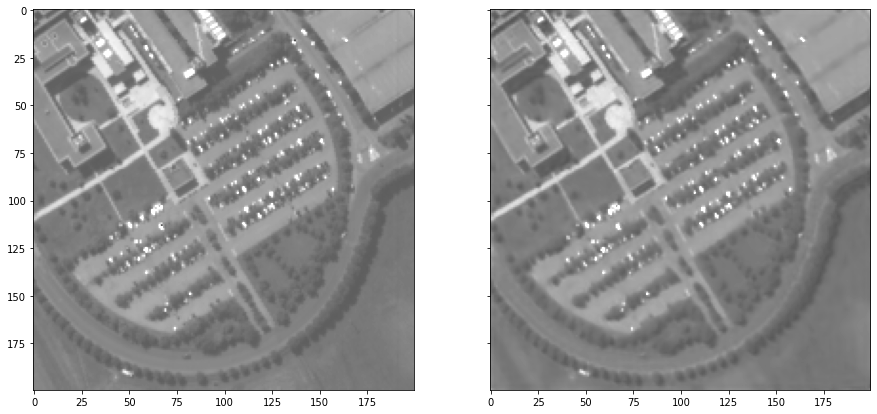

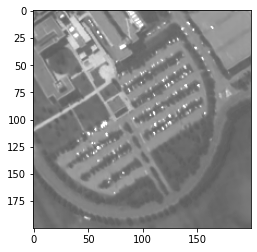

In [ ]:
psnr_history = []
if os.path.isfile(Path+'/results_HR.txt'):
  remove(Path+'/results_HR.txt')
if os.path.isfile(Path+'/results_LR.txt'):
  remove(Path+'/results_LR.txt')

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net2, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
torch.save(net2.state_dict(), '/content/gdrive/MyDrive/Colab Notebooks/sandwich/degradationModelH3H4')

In [ ]:
import pandas as pd
df_HR = pd.read_csv(Path+'/results_HR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_LR = pd.read_csv(Path+'/results_LR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_HR.head()

,PSNR_Spatial,PSNR_Spetral,PSNR_gen,RMSE,SNR,SAM,SSIM
0,12.480,5.0842,13.315,0.2158,3.1793,9.2798,0.7228
1,23.809,18.2540,24.517,0.0594,14.3810,6.6864,0.8447
2,24.870,19.0910,25.375,0.0538,15.2390,6.7232,0.8592
3,25.524,19.5330,25.872,0.0508,15.7360,6.6719,0.8699
4,26.097,20.5270,26.818,0.0456,16.6820,5.8723,0.8762


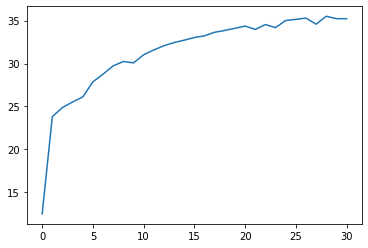

In [ ]:
df_HR["PSNR_Spatial"].plot()

In [ ]:
np.max(df_HR["PSNR_Spatial"])

In [ ]:
np.max(df_HR["PSNR_Spetral"])

In [ ]:
np.max(df_HR["PSNR_gen"])

In [ ]:
np.max(df_HR["SNR"])

In [ ]:
np.max(df_HR["SAM"])

In [ ]:
np.max(df_HR["SSIM"])

In [ ]:
  temp = np.zeros((imgs['HR2'].shape[0], imgs['HR2'].shape[1], imgs['HR2'].shape[2]))
  temp[100,100,:]=1.0
  #temp[101,101,:]=0.5

In [ ]:
OUT = temp.transpose(2,0,1)
OUT = torch.from_numpy(OUT).type(dtype)
OUT = OUT[None, :].cuda()

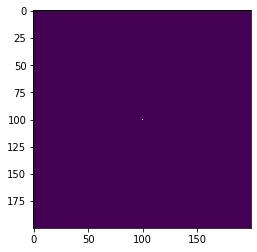

In [ ]:
plt.imshow(temp[:,:,9])

In [ ]:
out_BR = net2(OUT) # sale hyper
out_BR.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 12, 200, 200])

In [ ]:
OUT_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)

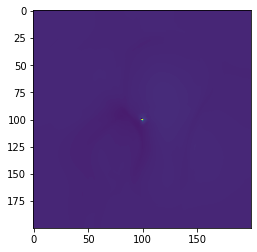

In [ ]:
plt.imshow(OUT_np[:, :, 9])

#H1-H4

In [ ]:
#H1-H4

net_input = img_Multi.type(dtype).detach()
net = skip(img_Multi.shape[1], HR.shape[1],
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)


net2 = skip(HR.shape[1],img_Multi.shape[1], 
           num_channels_down = [128]*5,
           num_channels_up =   [128]*5,
           num_channels_skip =    [4]*5,
           filter_size_up = 3,filter_size_down = 3,  filter_skip_size=1,
           upsample_mode='bilinear', # downsample_mode='avg',
           need1x1_up=False,
           need_sigmoid=False, need_bias=True, pad=pad, act_fun='LeakyReLU').type(dtype)

# Losses
mse = torch.nn.MSELoss().type(dtype)


In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    #H1
    out_HR = net(net_input) # entre hyper sale  high resultion

    # decimation
    out_LR = downsampler(out_HR) # entra high sale hyper
    out_spectral =  dw_spectral(out_HR) # entra high sale multi

    #H2
    out_BR = net2(out_HR) # entra high  sale multi

    #loss functions
    total_loss  = reg_loss[0] * mse(out_LR, img_hyper)
    total_loss += reg_loss[1] * mse(out_BR, img_Multi)
    total_loss += reg_loss[2] * mse(out_spectral ,out_BR )
    #total_loss = reg_loss[2] * mse(img_Multi ,out_BR)


    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()
    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    #psnr_LR = peak_signal_noise_ratio(img_Multi.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    psnr_LR = peak_signal_noise_ratio(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BR[0].detach().cpu().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))

    # History
    psnr_history.append([psnr_LR, psnr_HR])

    if i % show_every == 0:
        clear_output(wait=True)
        save_result(performance(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)),name_save+'/results_HR')
        #save_result(performance(img_Multi.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        save_result(performance(img_Multi[0].detach().cpu().numpy().transpose(1, 2, 0), out_BR[0].detach().cpu().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        out_Y_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        plt.imshow(out_Y_np[:, :, 0], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat(Path+"/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1

In [ ]:
num_iter=10001

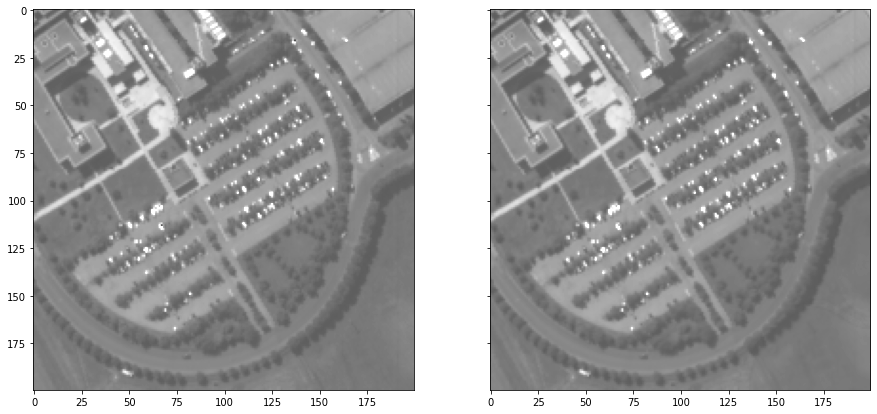

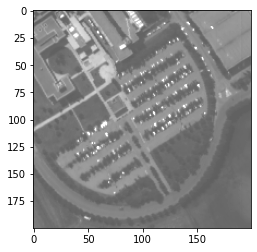

In [ ]:
psnr_history = []
if os.path.isfile(Path+'/results_HR.txt'):
  remove(Path+'/results_HR.txt')
if os.path.isfile(Path+'/results_LR.txt'):
  remove(Path+'/results_LR.txt')

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net2, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:
import pandas as pd
df_HR = pd.read_csv(Path+'/results_HR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_LR = pd.read_csv(Path+'/results_LR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_HR.head()

,PSNR_Spatial,PSNR_Spetral,PSNR_gen,RMSE,SNR,SAM,SSIM
0,7.9097,-2.216,4.8973,0.5690,-5.238,82.2590,0.1402
1,27.4190,21.330,28.0420,0.0396,17.905,5.9413,0.9223
2,30.2190,25.090,31.0290,0.0280,20.893,3.8352,0.9424
3,31.4660,26.802,32.2850,0.0243,22.149,3.1924,0.9515
4,32.1930,27.949,32.9970,0.0223,22.861,2.8531,0.9564


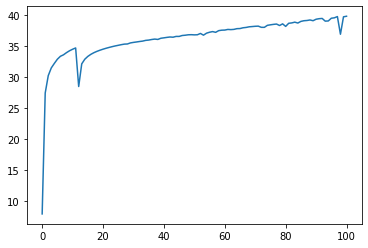

In [ ]:
df_HR["PSNR_Spatial"].plot()

In [ ]:
np.max(df_HR["PSNR_Spatial"])

39.801

In [ ]:
np.max(df_HR["PSNR_Spetral"])

38.327

In [ ]:
np.max(df_HR["PSNR_gen"])

39.72

In [ ]:
np.max(df_HR["SNR"])

29.584

In [ ]:
np.max(df_HR["SAM"])

82.259

In [ ]:
np.max(df_HR["SSIM"])

0.9893

In [ ]:
out_BR = net2(OUT) # sale hyper
out_BR.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 12, 200, 200])

In [ ]:
OUT_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)

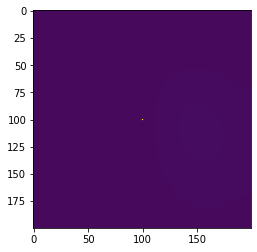

In [ ]:
plt.imshow(OUT_np[:, :, 9])

#H3-H2

In [ ]:
#H3-H2

net_input = img_hyper.type(dtype).detach()
net = UNet_up2( HR.shape[1], img_hyper.shape[1]).cuda()

net2 = UNet( HR.shape[1], img_hyper.shape[1]).cuda()
# Losses
mse = torch.nn.MSELoss().type(dtype)

In [ ]:
def closure():
    global i, net_input

    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    #H1
    out_HR = net(net_input) # entre Multi sale  high resultion

    # decimation
    out_LR = downsampler(out_HR) # entra high sale hyper
    out_spectral =  dw_spectral(out_HR) # entra high sale multi

    #H2
    out_BR = net2(out_HR) # sale hyper

    #loss functions
    total_loss  = reg_loss[0] * mse(out_BR, img_hyper)
    total_loss += reg_loss[1] * mse(out_spectral, img_Multi)
    total_loss += reg_loss[2] * mse(out_LR ,out_BR )
    #total_loss += reg_loss[2] * mse(img_hyper ,out_BR)


    if tv_weight > 0:
        total_loss += tv_weight * tv_loss(out_HR)

    total_loss.backward()

    # Log
    psnr_HR = peak_signal_noise_ratio(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)) 
    psnr_LR = peak_signal_noise_ratio(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0))
    print('Iteration {}, PSNR_HR {:.2f},  PSNR_LR {:.2f}, total_loss {:.5f} '.format(i, psnr_HR, psnr_LR, total_loss))

    # History
    psnr_history.append([psnr_LR, psnr_HR])

    if i % show_every == 0:
        clear_output(wait=True)
        save_result(performance(imgs['HR2'].astype(np.float32), out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)),name_save+'/results_HR')
        save_result(performance(img_hyper.detach().cpu().squeeze().numpy().transpose(1, 2, 0), out_BR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)), name_save+'/results_LR')
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        out_Y_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))
        ax1.imshow(imgs['HR2'][:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        ax2.imshow(np.clip(out_HR_np, 0, 1)[:, :, band], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()
        plt.imshow(out_Y_np[:, :, 5], cmap='gray', vmin=0.0, vmax=0.5)
        plt.show()

    if i % save_every == 0:
        out_HR_np = out_HR.detach().cpu().squeeze().numpy().transpose(1, 2, 0)
        scipy.io.savemat(Path+"/result_sr_2D_it%05d.mat" % (i), {'pred': np.clip(out_HR_np, 0, 1)})

    i += 1

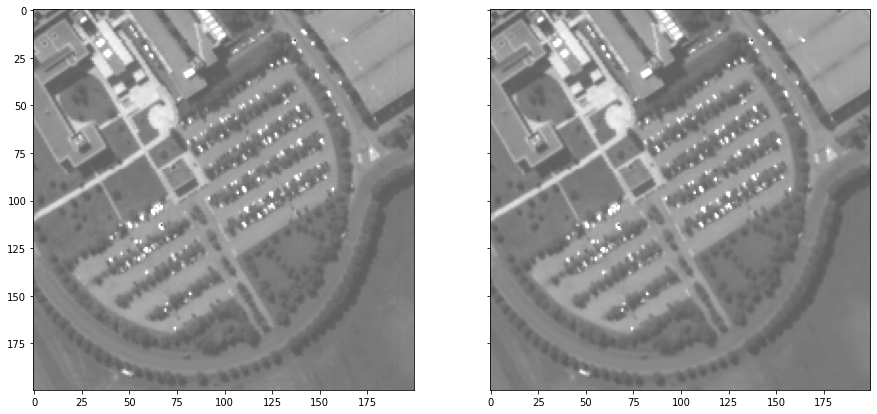

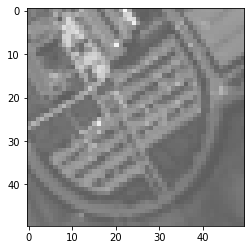

In [ ]:
psnr_history = []
if os.path.isfile(Path+'/results_HR.txt'):
  remove(Path+'/results_HR.txt')
if os.path.isfile(Path+'/results_LR.txt'):
  remove(Path+'/results_LR.txt')

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

i = 0
p = get_params(OPT_OVER, net, net2, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

In [ ]:


import pandas as pd
df_HR = pd.read_csv(Path+'/results_HR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_LR = pd.read_csv(Path+'/results_LR.txt', sep=",",names=["PSNR_Spatial", "PSNR_Spetral", "PSNR_gen", "RMSE", "SNR", "SAM", "SSIM"])
df_HR.head()

,PSNR_Spatial,PSNR_Spetral,PSNR_gen,RMSE,SNR,SAM,SSIM
0,12.501,5.1097,13.337,0.2153,3.2012,9.2529,0.7232
1,23.146,17.8820,24.000,0.0630,13.8640,6.6639,0.8392
2,24.953,19.2240,25.417,0.0535,15.2810,6.5495,0.8578
3,27.491,23.6200,28.440,0.0378,18.3030,3.5719,0.8889
4,28.842,25.3260,29.852,0.0321,19.7160,3.0298,0.9080


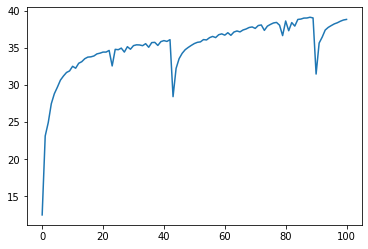

In [ ]:
df_HR["PSNR_Spatial"].plot()

In [ ]:
np.max(df_HR["PSNR_Spatial"])

39.153

In [ ]:
np.max(df_HR["PSNR_Spetral"])

35.789

In [ ]:
np.max(df_HR["PSNR_gen"])

39.161

In [ ]:
np.max(df_HR["SNR"])

29.025

In [ ]:
np.max(df_HR["SAM"])

9.2529

In [ ]:
np.max(df_HR["SSIM"])

0.9857

In [ ]:
out_BR = net2(OUT) # sale hyper
out_BR.shape

torch.Size([1, 96, 50, 50])

In [ ]:
OUT_np = out_BR.cpu().detach().numpy()[0].transpose(1, 2, 0)

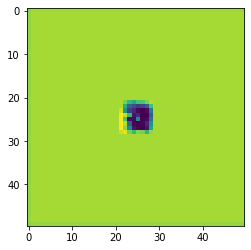

In [ ]:
plt.imshow(OUT_np[:, :, 9])

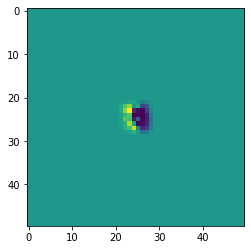

In [ ]:
plt.imshow(OUT_np[:, :, 95])

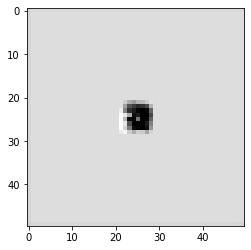

In [ ]:
plt.imshow(OUT_np[:, :, 9], cmap='gray')

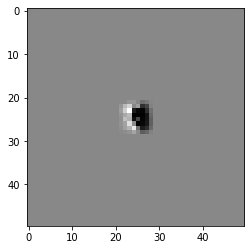

In [ ]:
plt.imshow(OUT_np[:, :, 95], cmap='gray')